Found 3065 .mat files to process
⚠️ Error reading /kaggle/input/figshare-datset/cvind.mat: "Unable to synchronously open object (object 'cjdata' doesn't exist)"
✅ Conversion complete. Images are stored in: /kaggle/working/brain_tumor_images_densenet
✅ Found 3064 images across 3 classes
🧾 Class distribution:
 class
glioma        1426
pituitary      930
meningioma     708
Name: count, dtype: int64
📊 Train: 2083, Val: 368, Test: 613
Found 2083 validated image filenames belonging to 3 classes.
Found 368 validated image filenames belonging to 3 classes.
Found 613 validated image filenames belonging to 3 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.6586 - loss: 1.0309 - val_accuracy: 0.7908 - val_loss: 0.6202
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 491ms/step - accuracy: 0.9341 - loss: 0.1807 - val_accuracy: 0.9321 - val_loss: 0.2114
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 493ms/step - accuracy: 0.9527 - loss: 0.1348 - val_accuracy: 0.9266 - val_loss: 0.2536
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 477ms/step - accuracy: 0.9746 - loss: 0.0629 - val_accuracy: 0.8995 - val_loss: 0.4701
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 490ms/step - accuracy: 0.9849 - loss: 0.0454 - val_accuracy: 0.9076 - val_loss: 0.5343
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 498ms/step - accuracy: 0.9634 - loss: 0.1094 - val_accuracy: 0.8397 - val_loss: 0.6261
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 498ms/step - accuracy: 0.9788 - loss: 0.0606 - val_accuracy: 0.8995 - val_loss: 0.4575
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 36s 549ms/step - accuracy: 0.9872 - loss: 0.0434 - val_accura

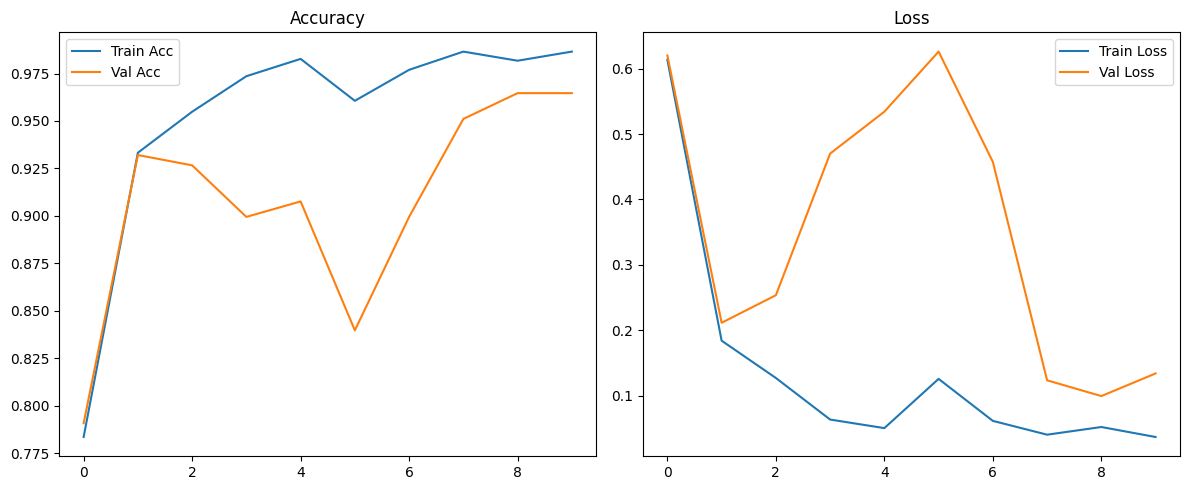

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 672ms/step - accuracy: 0.9586 - loss: 0.1164
✅ Test Accuracy: 0.9657
📉 Test Loss: 0.1127
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 826ms/step

Classification Report:
               precision    recall  f1-score   support

      glioma       0.99      0.95      0.97       285
  meningioma       0.95      0.95      0.95       142
   pituitary       0.94      0.99      0.97       186

    accuracy                           0.97       613
   macro avg       0.96      0.97      0.96       613
weighted avg       0.97      0.97      0.97       613



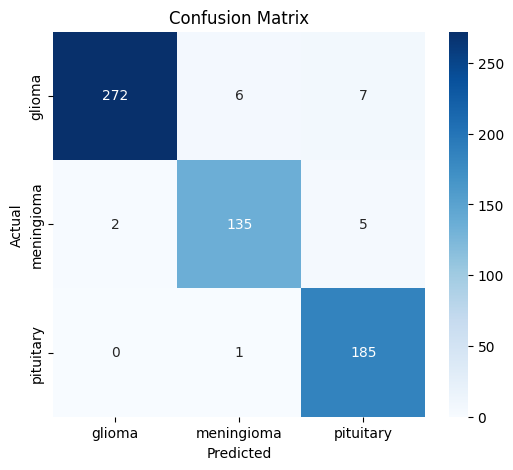

In [36]:
import os
import glob
import h5py
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# NOTE: DenseNet-specific import
from tensorflow.keras.applications.densenet import preprocess_input, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ======================
# ⚙️ Parameters
# ======================
DATASET_PATH = "/kaggle/input/figshare-datset"
IMAGE_PATH = "/kaggle/working/brain_tumor_images_densenet"
IMG_SIZE = (224, 224)  # DenseNet121 expects 224x224 just like VGG16
BATCH_SIZE = 32
EPOCHS = 10
os.makedirs(IMAGE_PATH, exist_ok=True)

# ======================
# 🗂 Step 0: Convert .mat → .png (unchanged)
# ======================
mat_files = glob.glob(os.path.join(DATASET_PATH, "**", "*.mat"), recursive=True)
print(f"Found {len(mat_files)} .mat files to process")
for f in mat_files:
    try:
        with h5py.File(f, "r") as mat:
            cjdata = mat["cjdata"]
            image = np.array(cjdata["image"]).T
            label = int(np.array(cjdata["label"])[0][0])  # 1=meningioma, 2=glioma, 3=pituitary
            if label == 1:
                cls = "meningioma"
            elif label == 2:
                cls = "glioma"
            elif label == 3:
                cls = "pituitary"
            else:
                cls = "unknown"
            out_dir = os.path.join(IMAGE_PATH, cls)
            os.makedirs(out_dir, exist_ok=True)
            img_norm = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")
            out_name = os.path.join(out_dir, os.path.basename(f).replace(".mat", ".png"))
            cv2.imwrite(out_name, img_norm)
    except Exception as e:
        print(f"⚠️ Error reading {f}: {e}")
print("✅ Conversion complete. Images are stored in:", IMAGE_PATH)

# ======================
# 🧠 Step 1: Collect all images (unchanged)
# ======================
image_paths = glob.glob(os.path.join(IMAGE_PATH, "**", "*.png"), recursive=True)
if len(image_paths) == 0:
    raise ValueError("❌ No images found after conversion!")
labels = [os.path.basename(os.path.dirname(p)) for p in image_paths]
df = pd.DataFrame({'filename': image_paths, 'class': labels})
NUM_CLASSES = df['class'].nunique()
print(f"✅ Found {len(df)} images across {NUM_CLASSES} classes")
print("🧾 Class distribution:\n", df['class'].value_counts())

# ======================
# 🧪 Step 2: Split dataset (unchanged)
# ======================
train_df, test_df = train_test_split(df, stratify=df['class'], test_size=0.20, random_state=42)
train_df, val_df = train_test_split(train_df, stratify=train_df['class'], test_size=0.15, random_state=42)
print(f"📊 Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# ======================
# 🔄 Step 3: Data generators (note DenseNet preprocess_input)
# ======================
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = train_datagen.flow_from_dataframe(train_df, x_col='filename', y_col='class',
                                              target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                              class_mode='categorical')
val_gen = valid_datagen.flow_from_dataframe(val_df, x_col='filename', y_col='class',
                                            target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                            class_mode='categorical')
test_gen = test_datagen.flow_from_dataframe(test_df, x_col='filename', y_col='class',
                                            target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                            class_mode='categorical', shuffle=False)

# ======================
# 🔧 Step 4: Build DenseNet121 model
# ======================
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
preds = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)

# ======================
# ⚙️ Step 5: Compile
# ======================
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ======================
# 📦 Step 6: Callbacks
# ======================
checkpoint = ModelCheckpoint('densenet121_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# ======================
# 🏋️ Step 7: Train
# ======================
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=EPOCHS,
                    callbacks=[checkpoint])

# ======================
# 📈 Step 8: Plot history (unchanged)
# ======================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# ======================
# 🧪 Step 9: Evaluate on test set
# ======================
loss, acc = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {acc:.4f}")
print(f"📉 Test Loss: {loss:.4f}")

# ======================
# 🧾 Step 10: Classification report & confusion matrix
# ======================
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)
class_labels = list(test_gen.class_indices.keys())
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
